In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython import display
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import multiprocessing as mp
import itertools
import time

import repitl.kernel_utils as ku
import repitl.matrix_itl as itl
import repitl.matrix_itl_approx as approx
import repitl.difference_of_entropies as dent

import models
import utils.visual_utils as vu
from utils.data_utils.multiview_dataset_maker import *

import utils.training_utils as tu
import utils.comparison_utils as cu
import utils.evaluation_metrics as em

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Create the multiview dataset

Setup training multiview set

In [2]:
batch_size = 3000
remake = False
dataset_name = "rot_noisy"

multiview_dataset = rot_noisy_multiview_dataset(check_for_saved=(not remake), noise_max=1, dataset_id=dataset_name, shuffle_view2 = True)

multiview_loader = DataLoader(dataset=multiview_dataset, 
                         batch_size=batch_size, 
                        
                         shuffle=False)

multiview_test =  rot_noisy_multiview_dataset(check_for_saved=(not remake), noise_max=1, is_testset=True, dataset_id=dataset_name, shuffle_view2=True)

multiview_test_loader = DataLoader(dataset=multiview_test, 
                         batch_size=1000, 
                         shuffle=False)

 Visualize multiview set

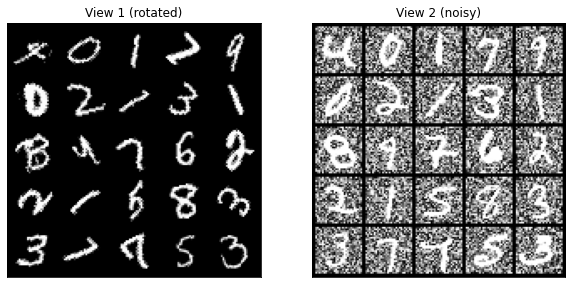

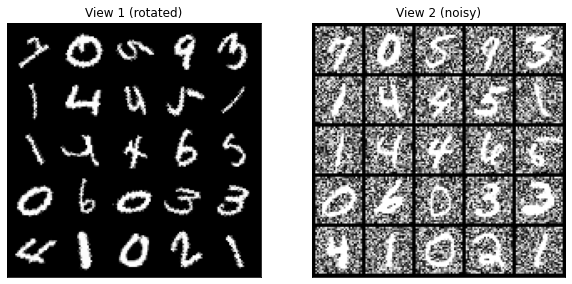

In [3]:
img_size = (1,28,28)
vu.visualize_multiview_dataset(multiview_loader, img_size=img_size, sidesize=5)
vu.visualize_multiview_dataset(multiview_test_loader, img_size=img_size, sidesize=5)

# Train DiME Model

Epoch 1
Batch 0 / 20  - Total 0.00 - Recon 0.000 - Latent -0.000010 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 2
Batch 0 / 20  - Total -0.28 - Recon 0.000 - Latent 0.281849 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 3
Batch 0 / 20  - Total -0.55 - Recon 0.000 - Latent 0.549800 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 4
Batch 0 / 20  - Total -0.67 - Recon 0.000 - Latent 0.665827 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 5
Batch 0 / 20  - Total -0.75 - Recon 0.000 - Latent 0.752979 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00


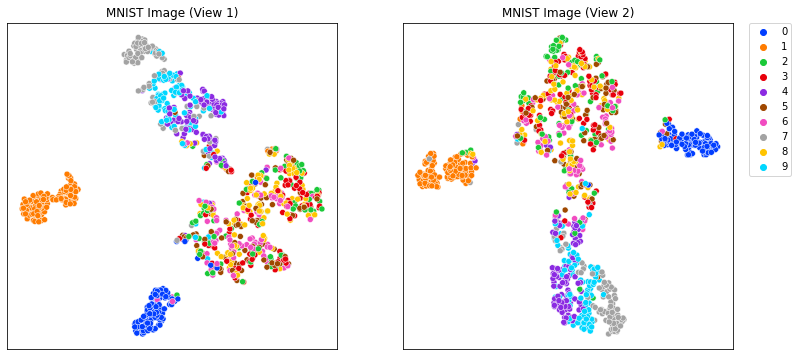

Epoch 6
Batch 0 / 20  - Total -0.84 - Recon 0.000 - Latent 0.837258 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 7
Batch 0 / 20  - Total -0.97 - Recon 0.000 - Latent 0.968724 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 8
Batch 0 / 20  - Total -1.11 - Recon 0.000 - Latent 1.109807 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 9
Batch 0 / 20  - Total -1.21 - Recon 0.000 - Latent 1.207428 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 10
Batch 0 / 20  - Total -1.29 - Recon 0.000 - Latent 1.294707 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00


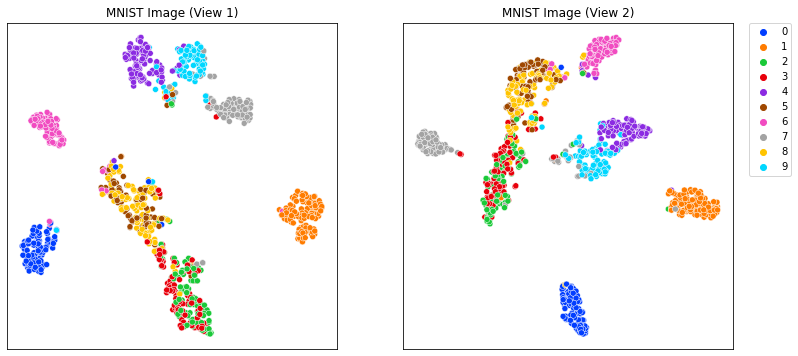

Epoch 11
Batch 0 / 20  - Total -1.37 - Recon 0.000 - Latent 1.367306 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 12
Batch 0 / 20  - Total -1.43 - Recon 0.000 - Latent 1.428596 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 13
Batch 0 / 20  - Total -1.49 - Recon 0.000 - Latent 1.493407 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 14
Batch 0 / 20  - Total -1.55 - Recon 0.000 - Latent 1.550920 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 15
Batch 0 / 20  - Total -1.59 - Recon 0.000 - Latent 1.591893 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00


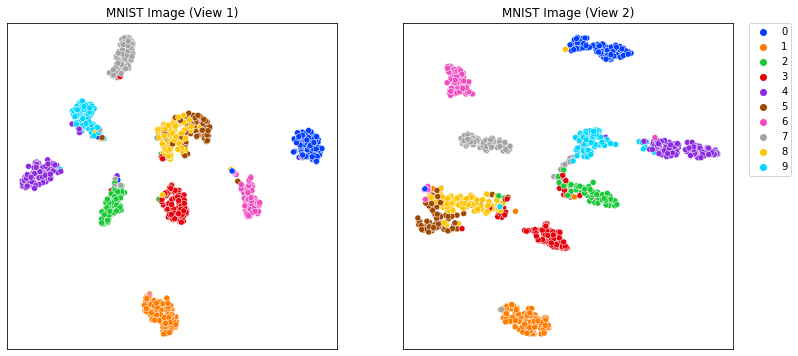

Epoch 16
Batch 0 / 20  - Total -1.63 - Recon 0.000 - Latent 1.626668 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 17
Batch 0 / 20  - Total -1.67 - Recon 0.000 - Latent 1.670469 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 18
Batch 0 / 20  - Total -1.71 - Recon 0.000 - Latent 1.706717 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 19
Batch 0 / 20  - Total -1.73 - Recon 0.000 - Latent 1.733727 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 20
Batch 0 / 20  - Total -1.76 - Recon 0.000 - Latent 1.755648 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00


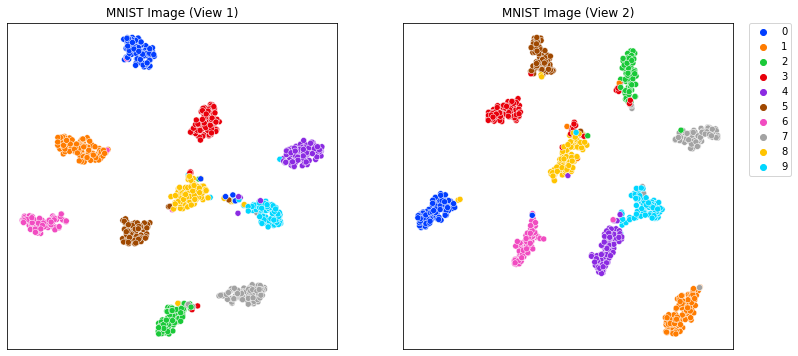

In [10]:
# to train with cca or cka, replace mv_doe with mv_cca or mv_cka. Can also do fully supervised classifier with mv_classifier

dime_model = tu.train_model("mv_doe", multiview_loader, multiview_test_loader, device=torch.device("cuda:1"), lr=0.0005, recon_dims=0,
            num_epochs=20, latent_dim=10, linear_size = 1024, img_size=(1,28,28), architecture="CNN",
            show_progress=True, num_classes=10, show_subprogress=True, experiment_name="dime", visualize_tsne=True)

# Update model with supervised classifier training

In [14]:
dime_model = tu.train_model("mv_doe_postclassfrozen", multiview_loader, multiview_test_loader, device=torch.device("cuda:1"), lr=0.0005, recon_dims=0,
            num_epochs=20, latent_dim=10, linear_size = 1024, img_size=(1,28,28), architecture="CNN",
            show_progress=True, num_classes=10, show_subprogress=True, experiment_name="dime", visualize_tsne=False)

mv_doe
freezing
391 10000
164 10000
Epoch 1   Acc 0.03910   0.01640 0.0005
Batch 0 / 20  - Total 5.04 - Recon 0.000 - Latent 0.000000 - Classifier 5.039 - Sigx 1.00 - Sigy 1.00
9329 10000
9373 10000
Epoch 2   Acc 0.93290   0.93730 0.0005
Batch 0 / 20  - Total 0.68 - Recon 0.000 - Latent 0.000000 - Classifier 0.682 - Sigx 1.00 - Sigy 1.00
9507 10000
9475 10000
Epoch 3   Acc 0.95070   0.94750 0.0005
Batch 0 / 20  - Total 0.45 - Recon 0.000 - Latent 0.000000 - Classifier 0.453 - Sigx 1.00 - Sigy 1.00
9536 10000
9493 10000
Epoch 4   Acc 0.95360   0.94930 0.0005
Batch 0 / 20  - Total 0.39 - Recon 0.000 - Latent 0.000000 - Classifier 0.393 - Sigx 1.00 - Sigy 1.00
9552 10000
9501 10000
Epoch 5   Acc 0.95520   0.95010 0.0005
Batch 0 / 20  - Total 0.37 - Recon 0.000 - Latent 0.000000 - Classifier 0.368 - Sigx 1.00 - Sigy 1.00
9552 10000
9502 10000
Epoch 6   Acc 0.95520   0.95020 0.0005
Batch 0 / 20  - Total 0.35 - Recon 0.000 - Latent 0.000000 - Classifier 0.355 - Sigx 1.00 - Sigy 1.00
9550 100